In [1]:
#%reset -f -s
%matplotlib inline
'''------------------------------------------------------------------
MA-eR-PINN: eRange Prediction using Physics-Informed Neural Networks
---------------------------------------------------------------------
Version: V2.1      Modified: 14.01.2025        William Siegle
---------------------------------------------------------------------
PTRAIN - Standard Pipeline Framework for Training the PINN
+ OPTUNA - Hyperparameter Optimization using Optuna
------------------------------------------------------------------''';

In [2]:
# MA-eR-PINN: CONFIGURATION FILE -------------------------------------------------
from pathlib import Path
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "GPU_SELECT":       0, # {0,1,2,3, None: CPU only}
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_pinn_2"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "SEED"  :           23,
    "PLOT_ACTIVE":      True,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.18, 0.02], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "MIN_SEQ_LENGTH":   5400, # minimum sequence length in s to be included in DataSets
    "SCALERS":          {'feature_scaler': 'StandardScaler()','target_scaler': 'StandardScaler()','prior_scaler': 'StandardScaler()'},

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ['accelpdlposn_cval','actdrvtrnpwrprc_cval','actualdcvoltage_pti1','actualspeed_pti1','actualtorque_pti1',
                        'airtempinsd_cval_hvac','airtempinsd_rq','airtempoutsd_cval_cpc','altitude_cval_ippc','brc_stat_brc1','brktempra_cval',
                        'bs_brk_cval','currpwr_contendrnbrkresist_cval','elcomp_pwrcons_cval','epto_pwr_cval','hv_bat_dc_momvolt_cval_bms1',
                        'hv_batavcelltemp_cval_bms1','hv_batcurr_cval_bms1','hv_batisores_cval_e2e','hv_batmaxchrgpwrlim_cval_1',
                        'hv_batmaxdischrgpwrlim_cval_1','hv_curr_cval_dcl1','hv_dclink_volt_cval_dcl1','hv_ptc_cabin1_pwr_cval','hv_pwr_cval_dcl1',
                        'lv_convpwr_cval_dcl1','maxrecuppwrprc_cval','maxtracpwrpct_cval','motortemperature_pti1','powerstagetemperature_pti1',
                        'rmsmotorcurrent_pti1','roadgrad_cval_pt','selgr_rq_pt','start_soc','txoiltemp_cval_tcm','vehspd_cval_cpc','vehweight_cval_pt'],                 
    "TARGETS":          ['hv_bat_soc_cval_bms1'],
    "PRIORS":           ['emot_soc_pred'],  

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      12,    # features in the hidden state h
    "NUM_LAYERS":       4,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.3,   # usually: [0.2 - 0.5]
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       2,
    "BATCH_SIZE":       32,         # [2, 4, 8, 16, 32, 64, 128, 256]
    "LEARNING_RATE":    2.8e-4,       # 0.001 lr
    "WEIGHT_DECAY":     1e-4,       # weight decay coefficient (default: 1e-2)
    "MOMENTUM_SGD":     0.1,        # (default: 0.0)
    "OPTIMIZER":        'adamw',    # ('adam', 'sgd', 'adamw')
    "WEIGHT_INIT_TYPE": 'normal',  # ('he', 'normal', 'default')
    "CLIP_GRAD":        1.0,        # default: None
    "LRSCHEDULER":      "torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)",  # constant LR for 1.0 as multiplicative factor

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", # ['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']
    "LOSS_FN":          "F.mse_loss(output, target)", # ['F.mse_loss(output, target)', 'F.l1_loss(output, target)', 'F.smooth_l1_loss(output, target)', 'F.huber_loss(output, target)', 'F.mase_loss(output, target)']
    "P_LOSS_FACTOR":    0.2, # Physics loss factor
}

In [3]:
# LOSS FUNCTION (REPLACE IN OBJECTIVE FUNCTION) ----------------------------------------------------------------   
def loss_fn_PINN_3(output, target, prior):
    l_p = P_LOSS_FACTOR
    y_pred = output; y_true = target; y_phys = prior
    total_loss = F.mse_loss(y_true, (l_p * y_phys + (1 - l_p) * y_pred), reduction='mean')
    return total_loss

___
SETUP: Locate devices & system folders

In [ ]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
import sys, os
for key in CONFIG: globals()[key] = CONFIG[key]
print(ROOT)
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
sys.path.append(os.path.abspath(ROOT))

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
from src.__init__ import *
from src.utils.data_utils import *
from src.utils.preprocess_utils import *
from src.utils.eval_utils import *
from src.utils.Trainers import *
from src.models.lstm_models import *

# SETUP ENVIRONMENT ---------------------------------------------------------------------
DATA_PATH, IS_NOTEBOOK, DEVICE, LOG_FILE_NAME, TS = setup_environment(CONFIG, ROOT, SEED, GPU_SELECT)

if not IS_NOTEBOOK:
    output_file = open(f"PTRAIN_{LOG_FILE_NAME}", "w")
    sys.stdout = Tee(sys.stdout, output_file); sys.stderr = Tee(sys.stderr, output_file)

/home/sieglew/MA-eR-PINN
------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			test, .git, archive, project, data, src
  /mnt/nvme/datasets/sieglew:			TripSequences
------------------------------------------------------------
Running in notebook mode
CONFIG Dictionary:
---------------------------------------------------------------------------------------------------------------------------------
     Parameter         Value
--  ----------------  ---------------------------------------------------------------------------------------------------------------
0   GPU_SELECT        0
1   ROOT              /home/sieglew/MA-eR-PINN
2   INPUT_LOCATION    TripSequences/trips_processed_pinn_2
3   OUTPUT_LOCATION   src/models/pth
4   SEED              23
5   PLOT_ACTIVE       True
6   TRAIN_VAL_TEST    [0.8, 0.18, 0.02]
7   MAX_FILES         None
8   MIN_SEQ_LENGTH    5400
9   SCALERS           {'feature_scaler': 'StandardScaler()', 'target_scale

___
DATA SELECTION & PREPROCESSING

In [5]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION)
files, trip_lengths, indices_by_length, sorted_trip_lengths, all_signals = prepare_data(input_folder, pth_folder, MAX_FILES, MIN_SEQ_LENGTH, ROOT)

------------------------------------------------------------
Total Files:	16116
Filtered Files:	2536
------------------------------------------------------------
               FileName  Length  Index
0       V13_T25.parquet   20843   1478
1      V18_T775.parquet   19425   1930
2      V13_T352.parquet   18308   1383
3      V18_T972.parquet   17858   2011
4     V16_T1629.parquet   17519   1750
...                 ...     ...    ...
2531   V13_T286.parquet    5408   1675
2532   V12_T852.parquet    5407   1722
2533   V13_T114.parquet    5407   2397
2534   V13_T736.parquet    5406   2276
2535   V14_T952.parquet    5401   2505

[2536 rows x 3 columns]


In [6]:
%%skip
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
                "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped (from Features) in order for appropriate training:
columns_to_drop = ["signal_time",                       # works as index
                    "hirestotalvehdist_cval_icuc",      # starts from 0, obtained by speed integration
                    "latitude_cval_ippc",               # only GPS 
                    "longitude_cval_ippc",              # only GPS
                    "hv_batpwr_cval_bms1",              # directly related to target (soc_gradient)
                    "hv_batmomavldischrgen_cval_1",     # indirect target 1 in kWh
                    "hv_bat_soc_cval_bms1",              # indirect target 2 in %SoC
                    "soc_gradient",                     # actual target signal   
                    "emot_pwr_cval",                    # replaced as physical prior for PINN
                    "emot_pwr_pred",                    # actual physical prior for PINN
                    ]

# Ensure no element of "columns_to_drop" is included in "FEATURES"
assert not any(col in FEATURES for col in columns_to_drop), "Some columns to drop are still in FEATURES"

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

In [7]:
# FEATURE SELECTION  ----------------------------------------------------------------------------
INPUT_COLUMNS = FEATURES; TARGET_COLUMN = TARGETS; PRIOR_COLUMN = PRIORS
print(f"{'-'*60}\nInput Signals:\t{len(FEATURES)}\nTarget Signals:\t{len(TARGETS)}\nPhysical Prior Signals:\t{len(PRIORS)}\n{'-'*60}")

# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])
prior_scaler = eval(SCALERS['prior_scaler'])

------------------------------------------------------------
Input Signals:	37
Target Signals:	1
Physical Prior Signals:	1
------------------------------------------------------------


In [8]:
# DATA SET SPLITTING AND SORTING ----------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

# DATALOADER SETTINGS ------------------------------------------------------------------
dataloader_settings = {'batch_size': 1, 'shuffle': True, 'collate_fn': collate_fn_PINN, 'num_workers': 8,
 'prefetch_factor': 4, 'persistent_workers': True, 'pin_memory': False if DEVICE.type == 'cpu' else True}

# PREPARE TRAIN, VAL & TEST DATALOADERS  ------------------------------------------------------------
train_subset, train_dataset, train_dataset_batches, train_loader = prepare_dataloader_PINN(train_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, fit=True, drop_last=True)

val_subset, val_dataset, val_dataset_batches, val_loader = prepare_dataloader_PINN(val_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=True)

test_subset, test_dataset, test_dataset_batches, test_loader = prepare_dataloader_PINN(test_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=False)

# print dataset info
subset_files = print_dataset_sizes(train_dataset, val_dataset, test_dataset, train_subset, val_subset, test_subset, files)

 --> Warning: Removed the last 13 samples to ensure a balanced batch size
fitting Scalers: StandardScaler, StandardScaler, StandardScaler
	50% of the fitting done...
Done. Create DataSets and DataLoaders...
	Number of batches created: 63
 --> Warning: Removed the last 9 samples to ensure a balanced batch size
	Number of batches created: 14
	Number of batches created: 2
------------------------------------------------------------
Train size:  17402267		(Files: 2016)
Val. size:   3893339		(Files: 448)
Test size:   454625		(Files: 50) 
 ------------------------------------------------------------
	Removed 22 file from the dataset
------------------------------------------------------------
first 3 train files: ['V13_T25.parquet', 'V18_T775.parquet', 'V13_T352.parquet']


In [9]:
# Load dataloaders
#train_loader = torch.load('train_loader.pth')
#val_loader = torch.load('val_loader.pth')
#test_loader = torch.load('test_loader.pth')

In [10]:
if IS_NOTEBOOK and False: 
    check_batch_PINN(train_loader)
    visualize_padding(BATCH_SIZE, trip_lengths, sorted_trip_lengths, train_loader, val_loader, test_loader)

___
MODEL & TRAINING CONFIGURATIONS

In [11]:
# LSTM NETWORK -----------------------------------------------------------------------

class LSTM1_packed_old_version(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device=DEVICE):
        super(LSTM1_packed_old_version, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first=True,dropout=self.dropout,device=device)

        # LAYERS -----------------------------------
        self.dropout_layer = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()

    def forward(self, packed_input, batch_size=None):
        packed_out, _ = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.relu(out)  # relu
        out = self.dropout_layer(out)  # dropout
        out = self.fc1(out)  # fully connected layer 1
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)  # relu
        out = self.fc2(out)  # fully connected layer 2
        return out

    # Define the weight initialization function for LSTM
    def initialize_weights_lstm(self, init_type):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')     # HE INIT
                elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.05)         # NORMAL INIT
                elif init_type == 'default': continue                                               # TORCH DEFAULT INIT
            elif 'bias' in name and init_type != 'default': nn.init.constant_(param.data, 0)

___
TRAINING

___
OPTUNA: Hyperparameter Optimization

------------------------------------------------------------
 LSTM1_packed_old_version(
  (lstm): LSTM(37, 12, num_layers=4, batch_first=True, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=12, out_features=6, bias=True)
  (bn1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
  (relu): ReLU()
) ------------------------------------------------------------
Model state_dict:
lstm.weight_ih_l0:	 torch.Size([48, 37])
lstm.weight_hh_l0:	 torch.Size([48, 12])
lstm.bias_ih_l0:	 torch.Size([48])
lstm.bias_hh_l0:	 torch.Size([48])
lstm.weight_ih_l1:	 torch.Size([48, 12])
lstm.weight_hh_l1:	 torch.Size([48, 12])
lstm.bias_ih_l1:	 torch.Size([48])
lstm.bias_hh_l1:	 torch.Size([48])
lstm.weight_ih_l2:	 torch.Size([48, 12])
lstm.weight_hh_l2:	 torch.Size([48, 12])
lstm.bias_ih_l2:	 torch.Size([48])
lstm.bias_hh_l2:	 torch.Size([48])
lstm.weight_ih_l3:	 torch.Size([48, 

Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/63 [00:00<?, ?batch/s]

/home/sieglew/.conda/envs/sieglew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/63 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:01:32
------------------------------------------------------------



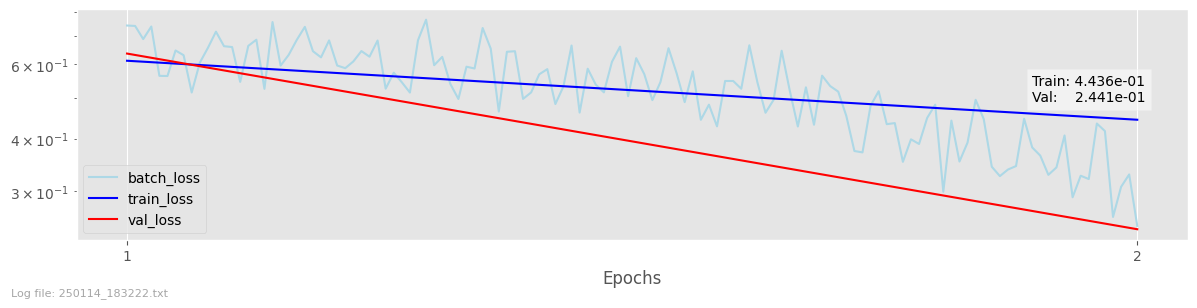

In [12]:
# TRAINING_CODE: -----------------------------------------------------------------
# INSTANTIATE MODEL AND APPLY WEIGHT INITIALIZATION --------------------
model = LSTM1_packed_old_version(len(INPUT_COLUMNS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
model.initialize_weights_lstm(WEIGHT_INIT_TYPE); print_info(model)

if OPTIMIZER=='adam': optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER=='adamw': optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
elif OPTIMIZER=='sgd': optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_SGD, weight_decay=WEIGHT_DECAY)

def lr_lambda(epoch):return 1.0

scheduler = eval(LRSCHEDULER); criterion = eval(CRITERION)

# LOSS FUNCTION ----------------------------------------------------------------   
def loss_fn_PINN_3(output, target, prior):
    l_p = P_LOSS_FACTOR
    y_pred = output; y_true = target; y_phys = prior
    total_loss = F.mse_loss(y_true, (l_p * y_phys + (1 - l_p) * y_pred), reduction='mean')
    return total_loss

# TRAIN -----------------------------------------------------------------
TRAINER = PTrainer_PINN(model = model, optimizer = optimizer, scheduler = scheduler,
    loss_fn = loss_fn_PINN_3, train_loader = train_loader, val_loader = val_loader, test_loader = test_loader, num_epochs = NUM_EPOCHS, device = DEVICE, is_notebook = IS_NOTEBOOK, 
    use_mixed_precision = True, clip_value = CLIP_GRAD, log_file = LOG_FILE_NAME)

RESULTS = TRAINER.train_model()
plot_training_performance(RESULTS)

# RETURN latest val_loss ---------------------------------------------------------
val_loss = RESULTS['val_losses'][-1]



___
SAVE CHECKPOINT

In [17]:
# SAVE MODEL -----------------------------------------------------------------
CHECKPOINT, model_destination_path = save_checkpoint(TRAINER, train_loader, val_loader, test_loader, RESULTS, CONFIG, subset_files, pth_folder, TS)

Model saved to:	 /home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_packed_old_version_250114_183222.pt
------------------------------------------------------------
Model ID: LSTM1_packed_old_version_250114_183222
------------------------------------------------------------
Size: 0.26 MB
------------------------------------------------------------


___
LOAD CHECKPOINT

In [18]:
# model_destination_path = Path(pth_folder, "LSTM1_packed_old_version_241216_082030.pth")

In [19]:
# LOAD MODEL -----------------------------------------------------------------
CHECKPOINT = load_checkpoint(model_destination_path, DEVICE)
for key in CHECKPOINT.keys(): globals()[key] = CHECKPOINT[key]
# load model and optimizer states --------------------------------------------
model.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)
model.eval()  # set model to evaluation mode for inference

Model loaded from:	/home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_packed_old_version_250114_183222.pt
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: cuda:0
------------------------------------------------------------
Train/Batch size:	63 / 32
Loss:			<function loss_fn_PINN_3 at 0x7f076d33c9a0>
Optimizer:		AdamW
LR:			0.00028
Weight Decay:		0.0001
------------------------------------------------------------



LSTM1_packed_old_version(
  (lstm): LSTM(37, 12, num_layers=4, batch_first=True, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=12, out_features=6, bias=True)
  (bn1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
  (relu): ReLU()
)

___
EVALUATION

In [20]:
# EVALUATION -----------------------------------------------------------------
# get file list of test subset
test_files = CHECKPOINT["test_files"]; print(f"{'-'*60}\nTest subset: {len(test_files)} files\n{'-'*60}")
# -------------------------------------
# evaluate model on test set
test_loss, all_outputs, all_targets, all_priors, all_original_lengths = TRAINER.evaluate_model()
# -------------------------------------
# Inverse-transform on all outputs and targets for evaluation
scaled_outputs = [target_scaler.inverse_transform(output_sequence.reshape(1, -1)).squeeze() for output_sequence in all_outputs]
scaled_targets = [target_scaler.inverse_transform(target_sequence.reshape(1, -1)).squeeze() for target_sequence in all_targets]
scaled_priors = [prior_scaler.inverse_transform(prior_sequence.reshape(1, -1)).squeeze() for prior_sequence in all_priors]

# concatenate:
all_y_true, all_y_pred, all_y_phys = np.concatenate(scaled_targets), np.concatenate(scaled_outputs), np.concatenate(scaled_priors)

# calculate evaluation metrics
print(f"Test Loss:\t\t{test_loss:.6f}")
metrics = calculate_metrics(all_y_true, all_y_pred) # [rmse, mae, std_dev, mape, r2, max_error]

# Variante auschecken!

------------------------------------------------------------
Test subset: 50 files
------------------------------------------------------------
Test Loss:		0.238243
RMSE:			12.7258        
MAE ± STD (MAPE):	10.6919 ± 12.6974 (24.08%)
R-squared:		0.6462


___
PLOT RESULTS

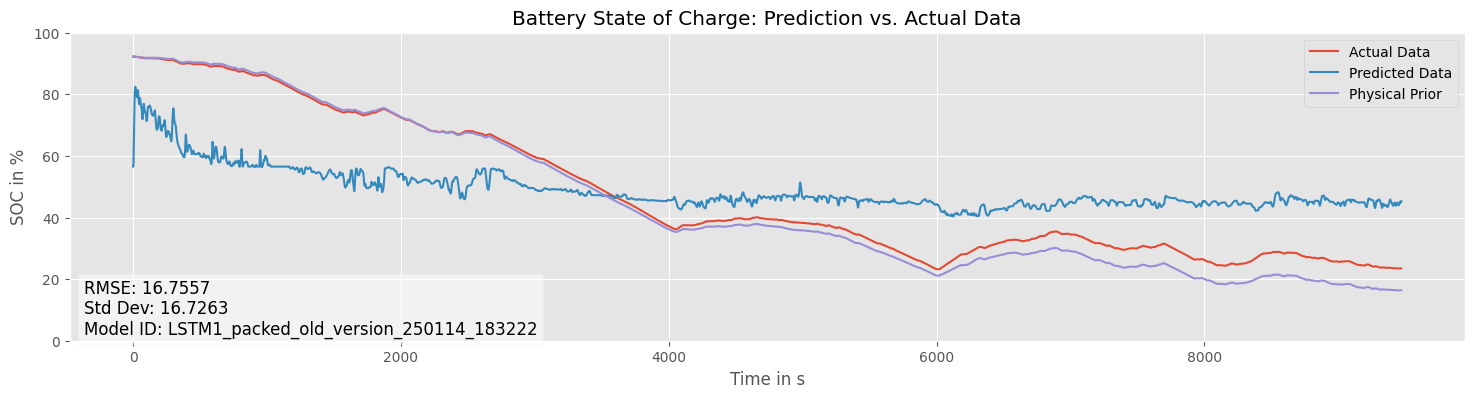

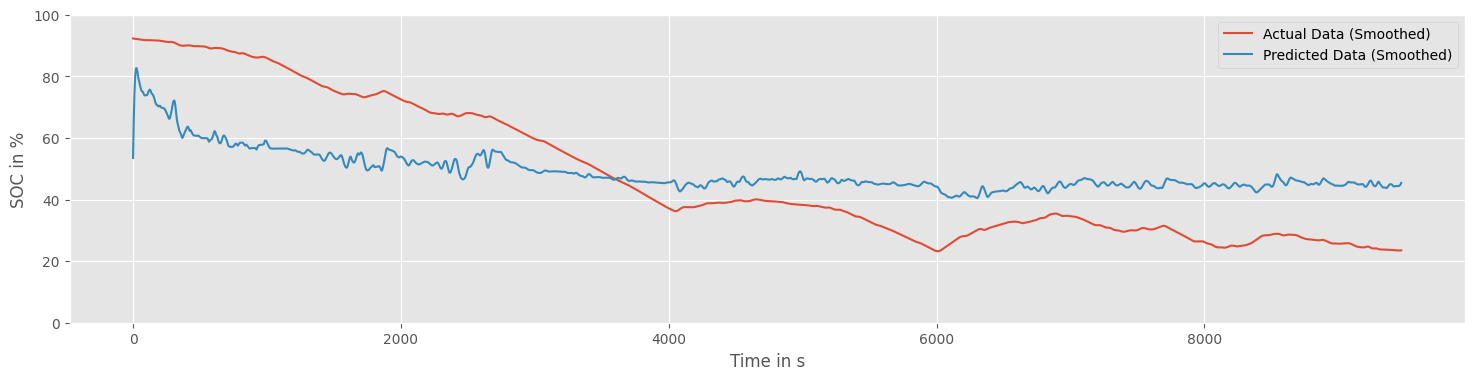

In [25]:
# get random sample sequence from test set
sample_int = random.randint(1, len(test_files)-1)
y_true, y_pred, y_phys = scaled_targets[sample_int], scaled_outputs[sample_int], scaled_priors[sample_int]

###############################################
# PLOT PREDICTION -----------------------------------------------------------------
if PLOT_ACTIVE:
     plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %'); plt.title('Battery State of Charge: Prediction vs. Actual Data') 
     plt.plot(y_true, label='Actual Data') # actual plot
     plt.plot(np.arange(0, len(y_true), 1), y_pred, label='Predicted Data') # predicted plot
     plt.plot(y_phys, label='Physical Prior') # physical prior
     plt.ylim(0, 100) # set y-axis limits

     plt.legend()
     plt.text(0.01, 0.02, f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}\nStd Dev: {np.std(y_true - y_pred):.4f}\nModel ID: {model_name_id}",\
          transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

     plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %')
     plt.plot(savgol_filter(y_true.flatten(), window_length=60, polyorder=3), label='Actual Data (Smoothed)') # actual plot
     plt.plot(np.arange(0, len(y_true), 1), savgol_filter(y_pred.flatten(), window_length=60, polyorder=3), label='Predicted Data (Smoothed)') # predicted plot
     plt.ylim(0, 100) # set y-axis limits
     plt.legend();

In [22]:
if not IS_NOTEBOOK: sys.stdout.close(); sys.stderr.close()